In [39]:
# Developed by: Ranjeet Kumar & Victor M. Zavala
# Implementation of scenario-based extensive form model for multi-stage stochastic programming
# UW-Madison, 2017

if (!isdefined(:JuMP)) using JuMP end
if (!isdefined(:Ipopt)) using Ipopt end
if (!isdefined(:PyPlot)) using PyPlot end

# generate plots or not
makeplots = 1;

# construct scenario tree
T = 3;         # Number of stages
NS = 3;        # Number of scenarios of disturbance at each stage
S = 1:NS;      # Scenario set per stage
Stages = 1:T;  # Set of stages

Nodes = Vector(); # Vector to contain all node ids (numbers)
NodeStage = Dict(); # Dictionary: Keys: Node ids, Values: Stage number in which given node is present
StageNodes = Dict(); # Dictionary: Keys: Stage numbers, Values: Corresponding node ids at given stage
NodeChildren = Dict(); # Dictionary: Keys: Node ids, Values: Corresponding children node ids for that node

# Filling up all dictionaries to create scenario tree
curnodeid = 1; # Current node id
push!(Nodes,curnodeid); # append new entry to vector
NodeStage[curnodeid] = 1;
StageNodes[1] = [curnodeid];
NodeChildren[1] = Vector();
for t in 2:T
	StageNodes[t] = Vector();
	for n in StageNodes[t-1]
		for s in S
			curnodeid+=1;
			push!(NodeChildren[n],curnodeid);
			NodeChildren[curnodeid] = Vector();
			NodeStage[curnodeid] = t;
			push!(StageNodes[t],curnodeid);
			push!(Nodes,curnodeid);
    end
  end
end

function getLeafs(n) # This function gives the node ids at the last stage which originate from n at some past stage
  if NodeStage[n] == T
		return [n];
	else
       tmp = [];
		for c in NodeChildren[n]
    	append!(tmp,getLeafs(c));
    end
  end
	return tmp;
end

Scens = getLeafs(1); # Scens contains all node ids at last stage (originating from root node n=1)
NScen = length(Scens); # Total number of scenarios in the tree (number of nodes in final stage of the tree)
ScensSeq = Dict(); # Dictionary: Keys: scenario ids, 
                    #          Values: Local node ids (1:NS) at every stage for node in last stage 
for s in Scens
  ScensSeq[s] = Vector(T);
  ScensSeq[s][1] = 1;
end
j=1;
for t in T:-1:2
  s = Scens[1];
  while(s<=Scens[end])
    for ss in 1:NS
      for i in 1:NS^(T-t)
        ScensSeq[s][t] = ss;
        s = s + 1;
        j=j+1
      end
    end
  end
end

# display some quantities to see tree structure
#print(Nodes)    # ids for nodes
#print(Stages)   # ids for stages
#print(StageNodes[1]) # stage of node 1
#print(StageNodes[6]) # stage of node 6
#print(getLeafs(1)) # get leafs of node 1
#print(getLeafs(364)) # get leafs of node 364


ScensSeq

Dict{Any,Any} with 9 entries:
  7  => Any[1, 1, 3]
  9  => Any[1, 2, 2]
  13 => Any[1, 3, 3]
  10 => Any[1, 2, 3]
  11 => Any[1, 3, 1]
  5  => Any[1, 1, 1]
  8  => Any[1, 2, 1]
  6  => Any[1, 1, 2]
  12 => Any[1, 3, 2]

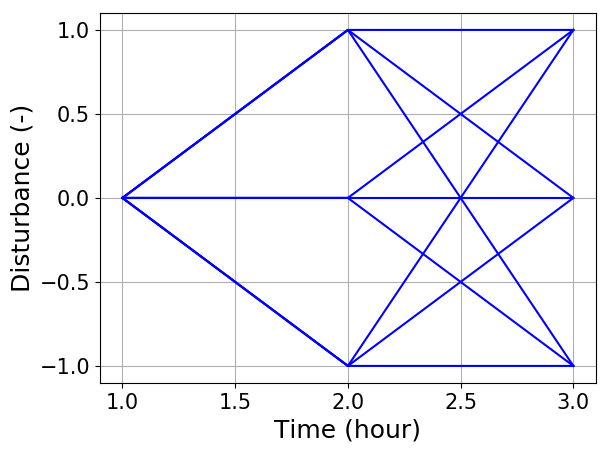

In [25]:
# disturbance data
load_scens = [-1 0 1]; # three scenarios of random disturbance profile: low, average and high

L = Matrix(T,NS); # Define an empty matrix
for s in 1:NS
  L[1,s] = mean(load_scens);
  for i in 2:T
    L[i,s] = load_scens[s];
  end
end

# plot disturbance tree pathways
figure()
grid()
Lmat=zeros(T,length(Scens))
for t in Stages 
    idx=0;
    for s in Scens 
        idx=idx+1
        Lmat[t,idx]=L[t,ScensSeq[s][t]]
    end
end
for s in 1:length(Scens)
plot(1:T,Lmat[:,s],color="blue")        
end
xlabel("Time (hour)", size=18)
ylabel("Disturbance (-)", size=18)
tick_params(labelsize=15)
savefig("disturbance_profile_tree.pdf")

In [3]:
######################################################
# MultiStage Stochastic Programming Model

m = Model(solver = IpoptSolver())
@variable(m, 0 <= x[Stages,Scens] <= 2) # state 
@variable(m, 0 <= u[Stages,Scens] <= 1) # control
@variable(m, 0 <= cost[Scens] <= 1) # cost

# objective function
@objective(m, Min, sum(cost[s] for s in Scens))
# initial condition
@constraint(m, Initial[t in Stages[1], s in Scens], x[t,s] == 1)
# dynamics
@constraint(m, Dynamics[t in Stages[2:end], s in Scens], x[t,s] == x[t-1,s] + u[t,s]*L[t,ScensSeq[s][t]])
# cost
@constraint(m, Costfunc[s in Scens], cost[s] == sum((1/(NS)^t)*(x[t,s]^2+u[t,s]^2) for t in Stages))

# Nonanticipativity: Decisions have to be same in all scenarios in the set S(n) [getLeafs(n)]
@constraint(m, Nonanticipativity[t in Stages[1:end-1], 
                                 n in StageNodes[t], 
                                 s in getLeafs(n), 
                                s1 in getLeafs(n)[1]], u[t,s] == u[t,s1])

# For two-stage use this relaxed nonanticipativity constraint
#@constraint(m, Nonanticipativity[t in Stages[1:1], 
#                                 n in StageNodes[t], 
#                                 s in getLeafs(n), 
#                                s1 in getLeafs(n)[1]], u[t,s] == u[t,s1])

status = solve(m)

:Optimal

In [4]:
# collect results
x = Matrix(T,NScen)
u = Matrix(T,NScen)
cost = Vector(NScen)

for t in 1:T
  ss = 1;
  for s in Scens
    x[t,ss] = getvalue(getvariable(m,:x)[t,s]);
    u[t,ss] = getvalue(getvariable(m,:u)[t,s]);
    ss = ss + 1;
  end
end

ss = 1;
for s in Scens
	cost[ss] = getvalue(getvariable(m,:cost)[s])
  ss = ss + 1;
end
obj_val = getobjectivevalue(m);

println("Expected total cost = $(obj_val)")


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.1, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    41918
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    10206

Total number of variables............................:    10935
                     variables with only lower bounds:        0
                variables with lower and upper bounds:    10935
                     variables with only upper bounds:        0
Total number of equa

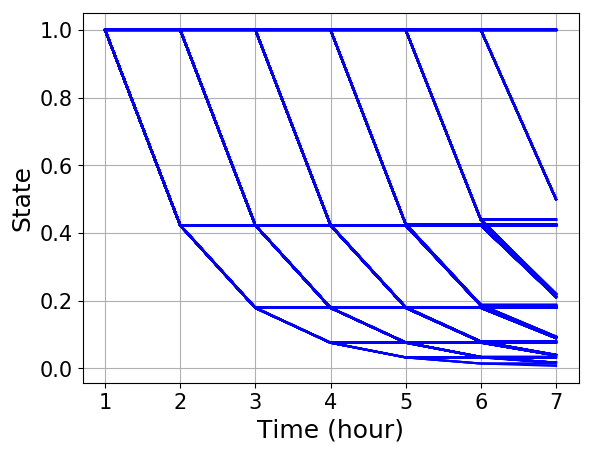

Expected total cost = 332.4663170133913


In [5]:
# plot state tree pathways
figure()
grid()
for s in 1:length(Scens)
plot(1:T,x[:,s],color="blue")        
end
xlabel("Time (hour)", size=18)
ylabel("State", size=18)
tick_params(labelsize=15)
savefig("state_profile_tree.pdf")

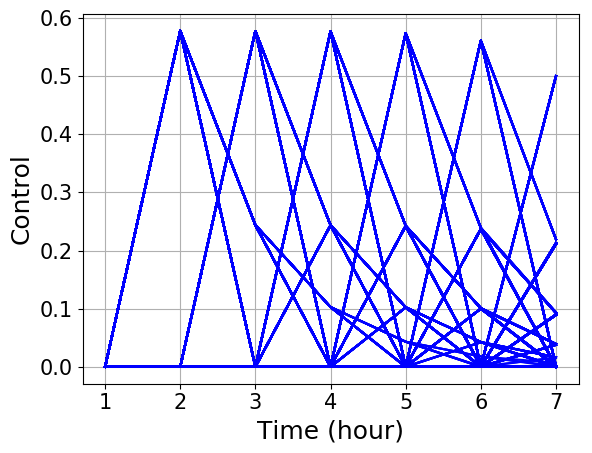

In [6]:
# plot control tree pathways
figure()
grid()
for s in 1:length(Scens)
plot(1:T,u[:,s],color="blue")        
end
xlabel("Time (hour)", size=18)
ylabel("Control", size=18)
tick_params(labelsize=15)
savefig("control_profile_tree.pdf")